In [1]:
from pareto_learning import MultiObjectiveModel
from harmonizer_analysis import Harmonizer
from utils import get_feature
import numpy as np
import matplotlib.pyplot as plt
import os, json
PATH = os.getcwd()

/home/theo/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Instruction

This notebook shows how to use Pareto self-supervision for LLM calibration.

Ingredients: Unlabeled data, LLM labels on the data, supervision functions.

A harmonizer model will be trained on the LLM labels and the supervision function labels.

Calibration score will be given by the harmonizer model on the test set.

### Example Data

You will need unlabeled data with input X. Gold label Y will be held out until evaluation. Weak labels L from the supervision functions and response L_llm from GPT models.

The following example load the CDR dataset for example. The task is to determine if the drug (entity 1) induces the disease (entity 2).

0: Negative
1: Positive
-1: Abstain (the supervision function was not triggered)

In [2]:
raw_text_feature = True
X, Y, L, L_llm = get_feature('cdr', raw_text_feature=raw_text_feature, gpt_model='gpt-4')

# Example data point
i = 100

# Input data
for _ in X['train'][i]:
    print(_+':', X['train'][i][_])

print('\n')

# Gold label
print('True label:', Y['train'][i])
    
print('\n')

# LLM response
print('LLM label:', L_llm['train'][i][0])
print('LLM response:', L_llm['train'][i][1])
    
print('\n')

# Supervision function weak labels
print('SF label:', L['train'][i])

text: We report the case of a patient in whom troleandomycin-induced hepatitis was followed by prolonged anicteric cholestasis.
entity1: troleandomycin
entity2: cholestasis
span1: [40, 54]
span2: [109, 120]


True label: 1


LLM label: 1
LLM response: Positive

The text describes a patient who developed hepatitis after using troleandomycin, which was then followed by prolonged anicteric cholestasis. This suggests a temporal relationship between the drug troleandomycin (Entity 1) and the disease cholestasis (Entity 2). Therefore, it is likely that troleandomycin induced cholestasis in this case.


SF label: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


### Train Harmonizer

In this step we train a harmonizer model on the LLM labels and the SF labels using Pareto learning.

The basic idea is to minimize the loss of the harmonizer model matching all the sources simultaneouly. 

A Pareto scalarizer function $G(\ell_0, \ell_1, \cdots, \ell_m)$ is used to aggregate the losses.

For simple harmonizer models like Logistic regression or MLP, linear combination works well.

For deeper harmonizer models like BERT, nonlinear function like quadratic $G(\ell_0, \ell_1, \cdots, \ell_m) = (\sum_{j=0}^m \ell_j)^2$ is recommended.

In [3]:
# Combine LLM label with the SF weak labels
# LLM label becomes is LAST one in all the labels in L
for fold in L:
    for i in range(len(L[fold])):
        L[fold][i].append(L_llm[fold][i][0])

# example weak label format
print('Example weak label format (last one in each row is from the LLM):', L['train'][:3])

Example weak label format (last one in each row is from the LLM): [[-1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0], [-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0]]


The class MultiObjectiveModel implements harmonizer training.

model_type: Harmonizer model type. My current code supports the following options (adding other types should be easy): 

    LR (Logistic regression), MLP (multi-layer perceptron). Both takes pre-computed feature vectors as input.

    BERTre for relation extraction. Input format: List({'text': raw text string, 
        'span1': [start char id of entity 1, end char id of entity 1], 
        'span2': [start char id of entity 2, end char id of entity 2]})
        
    BERTclf for classification. Input format: List of raw text strings.

loss_aggr: Pareto scalarizer function to aggregate the losses. Options are: linear, square, 2-norm, max (not recommended).

In [4]:
input_size = None if raw_text_feature else len(X['train'][0])

# Specify harmonizer training
harmonizer = MultiObjectiveModel(model_type='BERTre', loss_aggr='square', input_size=input_size, batch_size=16)
# Fit on training data with the weak labels and LLM labels
harmonizer.fit(X['train'], L['train'], max_epoch=1)    # change number of epochs for better results!

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 527/527 [02:50<00:00,  3.10it/s]

0.0036942487740730164 

### Calibration Score

The probability from the harmonizer model will be used for calibration score. 

The Harmonizer class is useful in operating on the class probability from the harmonizer.

In [5]:
# Harmonizer make probability prediction on the test examples we want calibration score
probas = harmonizer.predict_proba(X['test'])

# Analysis based on predicted probabilities
h = Harmonizer(probas=probas)

100%|██████████| 293/293 [01:04<00:00,  4.52it/s]


For each source, we rank the examples by their risk scores. The LLM is the last source.

In [6]:
# Rank the test examples by POLAR score
polar_scores = h.rank_doubt_scores(weak_labels=L['test'])

# check the LLM source
j = len(L['test'][0]) - 1    # the last source
# Top risky examples: (POLAR score, example ID, harmonizer prediction)
polar_scores[j][:5]

[(0.9155793786048889, 4055, 0),
 (0.9034601897001266, 4043, 0),
 (0.9032190591096878, 44, 0),
 (0.9014477133750916, 1388, 0),
 (0.8994420245289803, 1387, 0)]

In [7]:
# Pick a high risk example to see LLM performance
ii = 0
risk, i, h_pred = polar_scores[j][ii]

print('Risk score:', risk)
print('True label:', Y['test'][i])
print('LLM response:', L_llm['test'][i][1])

Risk score: 0.9155793786048889
True label: 0
LLM response: Positive

In the given text, it is mentioned that 5-Fluorouracil, in combination with folinic acid and paclitaxel, is an effective salvage therapy for metastatic breast cancer patients. This indicates that 5-Fluorouracil (Entity 1) is used to treat breast cancer (Entity 2), suggesting a positive relationship between the drug and the disease.


If you have gold labels on the test set, you can plot calibration graph as follows.

Text(0, 0.5, 'LLM error rate')

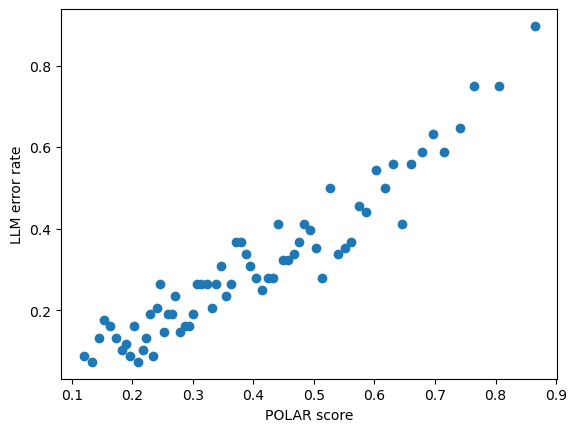

In [8]:
error_rate_bin, doubt_score_bin, error_rate_bin_new = h.correlation_scatter(L['test'], Y['test'])
plt.scatter(doubt_score_bin, error_rate_bin)
plt.xlabel('POLAR score')
plt.ylabel('LLM error rate')

### Dynamic Self-supervision

The supervision functions for the CDR dataset are based on knowledge base, keywords, or expression pattern check. We use these supervision functions to provide evidence to the LLM after it gave the initial response.

In [10]:
from rule_explanations import get_explanation_from_lfs

# use the supervision functions to provide evidences
print(get_explanation_from_lfs(X['test'][i], L['test'][i][:-1]))

Based on the expression '5-Fluorouracil plus folinic acid and paclitaxel (Taxol; Bristol-Myers Squibb Company, Princeton, NJ) are effective salvage therapies for metastatic breast cancer', 5-Fluorouracil actually treats breast cancer. , so it is not likely that 5-Fluorouracil induces breast cancer. According to the Comparative Toxicogenomics Database, the given chemical-condition pair "5-Fluorouracil-breast cancer" is listed that the chemical actually treats the condition, so the answer that 5-Fluorouracil does not induce breast cancer is confirmed. According to the Comparative Toxicogenomics Database, the relation between the given chemical-condition pair is listed, confirming the answer. 5-Fluorouracil and breast cancer are not closely mentioned in the text, so it is not likely that 5-Fluorouracil induces breast cancer. 


In [11]:
# Full follow-up prompt to GPT
print('It is possible that the answer could be something else. Here are some evidences to help you figure out the right answer. ')
print(get_explanation_from_lfs(X['test'][i], L['test'][i][:-1]))
print('Are you sure about your previous answer? If not, please give a new answer. Otherwise, please restate your previous answer.')

It is possible that the answer could be something else. Here are some evidences to help you figure out the right answer. 
Based on the expression '5-Fluorouracil plus folinic acid and paclitaxel (Taxol; Bristol-Myers Squibb Company, Princeton, NJ) are effective salvage therapies for metastatic breast cancer', 5-Fluorouracil actually treats breast cancer. , so it is not likely that 5-Fluorouracil induces breast cancer. According to the Comparative Toxicogenomics Database, the given chemical-condition pair "5-Fluorouracil-breast cancer" is listed that the chemical actually treats the condition, so the answer that 5-Fluorouracil does not induce breast cancer is confirmed. According to the Comparative Toxicogenomics Database, the relation between the given chemical-condition pair is listed, confirming the answer. 5-Fluorouracil and breast cancer are not closely mentioned in the text, so it is not likely that 5-Fluorouracil induces breast cancer. 
Are you sure about your previous answer? If

Let's plot the error rate of the new LLM responses on the test set.

In [12]:
new_version = 'explain'
# New LLM labels
new_LLM_labels = json.load(open(os.path.join(PATH, 'LLM_labels', 'gpt-4', new_version, 'cdr', 'test.json')))
error_rate_bin, doubt_score_bin, error_rate_bin_new = h.correlation_scatter(L['test'], Y['test'], new_LLM_labels)

Plot error rate comparision

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_dynamic_prompting_curves(error_rate_bin, doubt_score_bin, error_rate_bin_new):
    # Sample data
    x = np.array(doubt_score_bin)
    y = np.array(error_rate_bin)
    # Calculate lowess smooth
    ys = lowess(y, x, frac=0.5)[:, 1]
    xs = lowess(y, x, frac=0.5)[:, 0]
    # Bootstrap to estimate the 95% confidence intervals
    n_bootstraps = 1000
    bootstrap_ys = np.zeros((n_bootstraps, len(x)))
    for i in range(n_bootstraps):
        sample_index = np.random.choice(range(len(x)), len(x), replace=True)
        bootstrap_ys[i, :] = lowess(y[sample_index], x[sample_index], frac=0.5)[:, 1]
    lower_bound = np.percentile(bootstrap_ys, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_ys, 97.5, axis=0)
    lower_bound = ys + np.std(bootstrap_ys, axis=0)
    upper_bound = ys - np.std(bootstrap_ys, axis=0)


    y_new = np.array(error_rate_bin_new)
    # Calculate lowess smooth
    ys_new = lowess(y_new, x, frac=0.5)[:, 1]
    # Bootstrap to estimate the 95% confidence intervals
    n_bootstraps = 1000
    bootstrap_ys_new = np.zeros((n_bootstraps, len(x)))
    for i in range(n_bootstraps):
        sample_index = np.random.choice(range(len(x)), len(x), replace=True)
        bootstrap_ys_new[i, :] = lowess(y_new[sample_index], x[sample_index], frac=0.5)[:, 1]
    lower_bound_new = ys_new + np.std(bootstrap_ys_new, axis=0)
    upper_bound_new = ys_new - np.std(bootstrap_ys_new, axis=0)


    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(7, 6))  # Size of the plot

    #ax.scatter(x, y, label='Data points')  # Scatter plot
    ax.plot(xs, ys, color='red', label='Initial GPT-4 response')  # Smoothed line
    # Plot the error range
    ax.fill_between(xs, lower_bound, upper_bound, color='red', alpha=0.2)


    #ax.scatter(x, y_new, label='Data points')  # Scatter plot
    ax.plot(xs, ys_new, color='blue', label='GPT-4 response after dynamic prompting')  # Smoothed line
    # Plot the error range
    ax.fill_between(xs, lower_bound_new, upper_bound_new, color='blue', alpha=0.2)



    ax.set_xlabel('POLAR risk score', fontsize=14)
    ax.set_ylabel('Response error rate', fontsize=14)
    ax.set_title('Error rate before and after dynamic prompting', fontsize=16)
    ax.legend(loc='upper left', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    # Remove the grid lines
    ax.grid(False)

Text(0.5, 1.0, 'Error rate before and after dynamic self-supervision')

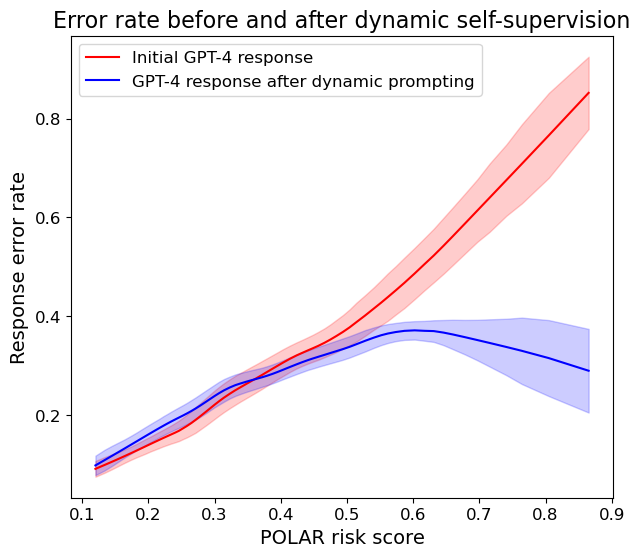

In [14]:
plot_dynamic_prompting_curves(error_rate_bin, doubt_score_bin, error_rate_bin_new)
plt.title('Error rate before and after dynamic self-supervision', fontsize=16)

### Dynamic Self-examination

If getting evidence from the supervision functions is hard, simply ask the LLM to self-examine is also helpful. Below is the follow-up prompt to GPT. 

In [15]:
print('Are you sure about your previous answer? If not, please give a new answer. Otherwise, please restate your previous answer.')

Are you sure about your previous answer? If not, please give a new answer. Otherwise, please restate your previous answer.


Let's plot the error rate change after dynamic prompting. Note that it should be performed only when POLAR score is high.

Text(0.5, 1.0, 'Error rate before and after dynamic self-examination')

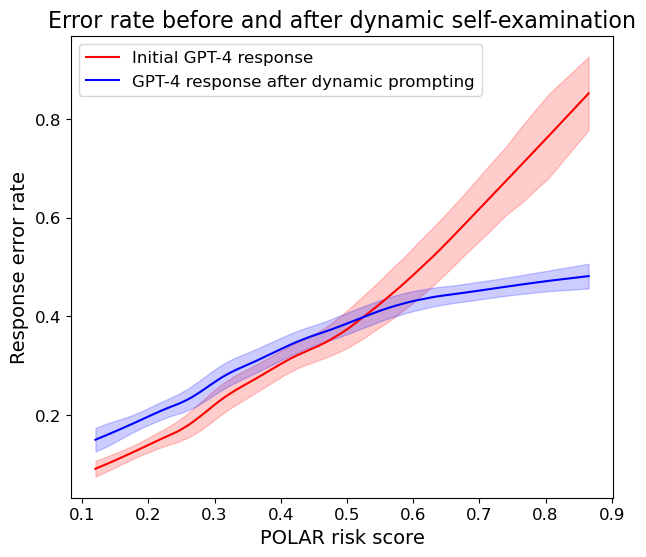

In [16]:
new_version = 'reask'
# New LLM labels
new_LLM_labels = json.load(open(os.path.join(PATH, 'LLM_labels', 'gpt-4', new_version, 'cdr', 'test.json')))
error_rate_bin, doubt_score_bin, error_rate_bin_new = h.correlation_scatter(L['test'], Y['test'], new_LLM_labels)

plot_dynamic_prompting_curves(error_rate_bin, doubt_score_bin, error_rate_bin_new)
plt.title('Error rate before and after dynamic self-examination', fontsize=16)